In [1]:
using Knet: Knet, dir, accuracy, progress, sgd, load, save, gc, Param, KnetArray, Data, minibatch, nll, relu, training, dropout
using Statistics
using CUDA
using Random
using LinearAlgebra
using Knet
using Plots; default(fmt=:png,ls=:auto)
using ProgressBars
using NBInclude

┌ Warning: Your Tesla K20m GPU does not meet the minimal required compute capability (3.5.0 < 5.0).
│ Some functionality might not work. For a fully-supported set-up, please use an older version of CUDA.jl
└ @ CUDA /kuacc/users/hcoban15/.julia/packages/CUDA/YeS8q/src/state.jl:251


In [2]:
if CUDA.functional()
    atype = KnetArray{Float32};
else
    atype = Array{Float32};
end

KnetArray{Float32,N} where N

# Random Deals and Hand Features
Hands are represented with 52-bit vectors and bidding history with 36-bit vectors.

In [3]:
@nbinclude("deal_features.ipynb")

human_readable (generic function with 1 method)

# Deep Q-network Model

In [4]:
@nbinclude("model.ipynb")


sgdupdate! (generic function with 1 method)

In [5]:
function init()
    Q1=Chain(Dense(52,128),Dense(128,128),Dense(128,128),Dense(128,36,identity));
    Q2=Chain(Dense(52+36,128),Dense(128,128),Dense(128,128),Dense(128,36,identity));
    Q3=Chain(Dense(52+36,128),Dense(128,128),Dense(128,128),Dense(128,36,identity));
    Q4=Chain(Dense(52+36,128),Dense(128,128),Dense(128,128),Dense(128,36,identity));
    Q5=Chain(Dense(52+36,128),Dense(128,128),Dense(128,128),Dense(128,36,identity));
    Q6=Chain(Dense(52+36,128),Dense(128,128),Dense(128,128),Dense(128,36,identity));
    Q=[Q1,Q2,Q3,Q4,Q5,Q6];
    return Q
end

init (generic function with 1 method)

In [6]:
#hyper parameters
epsilon_greedy=0.05;
turn_depth=6;
learning_rate=0.1;
batch_size=50;
instance_size=1000;

# Hand Reading From txt


Generate a data instance from a PBN-formatted txt 

In [7]:
@nbinclude("hand_reading.ipynb")

file= open("test_hamza.txt","r");
lines=readlines(file);
deal_data=[]
for deal in lines
    north=PBN_to_vector(deal[18:33])
    south=PBN_to_vector(deal[52:67])
    costs=PBN_to_cost(deal[69:end])
    push!(deal_data,(north,south,costs))

end

training_set=deal_data[1:4000];
test_set=deal_data[4001:end];


# Main Learning Algorithm

In [8]:
@nbinclude("target_determine.ipynb")
@nbinclude("explore.ipynb")
@nbinclude("bid_functions.ipynb")

bid (generic function with 1 method)

In [9]:
function train!(Q,training_set,test_set;iteration_size=1000,progress=true,epsilon_greedy=0.05, batchsize=50,learning_rate=0.1,periods=10,turn_depth=6)
    database_target_training=[[],[],[],[],[],[]];
    database_state_training=[[],[],[],[],[],[]];
    data_state_and_action=[[],[],[],[],[],[]];
    data_state_all_bid=[];
    history_of_Q=[];
    push!(history_of_Q,deepcopy(Q));
    if progress
        iterator= ProgressBar(1:iteration_size)
    else
        iterator= 1:iteration_size
    end
    for i in iterator
        bid!(Q,training_set[rand(1:end)],database_state_training,database_target_training,data_state_all_bid,epsilon_greedy)
        #Experience Replay
        for t in 1:turn_depth
            copy_database_target=copy(database_target_training[t]);
            copy_database_state=copy(database_state_training[t]);
            data=minibatch(hcat(copy_database_state...),hcat(copy_database_target...),batch_size,shuffle=true);
            if summary(data)[1]=='0'#if no minibatch
            else
                #take a single minibatch
                x,y=first(data);
                sgdupdate!(Q[t],x,y,lr=learning_rate);
            end
        end
        if i%periods==0
           push!(history_of_Q,deepcopy(Q));
        end
    end
   return history_of_Q,database_target_training,database_state_training,data_state_all_bid
    end;

    

In [10]:
Q=init();
history_of_Q,database_target_training,database_state_training,data_state_all_bid=train!(Q,training_set,
    test_set,iteration_size=1000,progress=true,periods=20);

100.0%┣██████████████████████████████████████┫ 1000/1000 [02:00<00:00, 8.3 it/s]▉            ┫ 697/1000 [01:26<00:37, 8.1 it/s]


An instance of a decleration history

In [18]:
n,s,bidding=bid(Q,deal_data[rand(1:end)],debug=true)
println(human_readable(n))
println(human_readable(s))
for i in 1:36
    if bidding[i]==1
        println(bids[i])
    end
end

1 bid
cost = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.48, 0.44, 0.48, 0.44, 0.4, 0.48, 0.44, 0.52, 0.48, 0.44, 0.48, 0.48, 0.52, 0.48]
Array(q_values) = Float32[1.0007671, 0.9536944, 0.9030197, 0.9622078, 0.93776685, 0.9465756, 0.96037966, 0.83385926, 0.915177, 0.86779356, 0.98223484, 0.8945593, 0.81793326, 0.9316165, 0.93145365, 0.8683901, 0.8153772, 0.81809276, 0.8538028, 0.7507381, 0.82185113, 0.7795986, 0.71243715, 0.8703846, 0.71712834, 0.8234448, 0.6018502, 0.66446555, 0.6664697, 0.5496834, 0.66759723, 0.5262051, 0.6412017, 0.506054, 0.6075272, 0.44625622]
2 bid
cost = [1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 0.48]
Array(q_values) = Float32[-0.16891377, -0.065448806, -0.18156993, -0.31106943, -0.17861003, -0.014856456, -0.2591427, -0.19836694, -0.17155325, -0.3922462, -0.24553

# Calculate and Plot the Average Losses of every Epoch

In [11]:
test_losses=[[],[],[],[],[],[]];
train_losses=[[],[],[],[],[],[]];

for epoch in ProgressBar(history_of_Q)
    database_state, database_target= bid_to_the_end(epoch,training_set,100)
    database_state_test, database_target_test= bid_to_the_end(epoch,test_set,100)
    for i in 1:6
        data=minibatch(hcat(database_state[i]...),hcat(database_target[i]...),batch_size,shuffle=true);
        push!(train_losses[i],epoch[i](first(data)));
        data=minibatch(hcat(database_state_test[i]...),hcat(database_target_test[i]...),batch_size,shuffle=true);
        push!(test_losses[i],epoch[i](first(data)));
        
    end
end

100.0%┣██████████████████████████████████████████┫ 51/51 [00:17<00:00, 2.9 it/s]


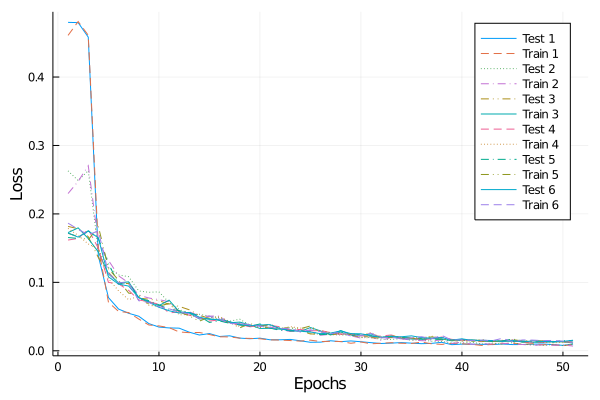

In [12]:
# Comparison to MLP shows faster convergence, better generalization
plot(test_losses[1],label="Test 1",xlabel="Epochs",ylabel="Loss")
plot!(train_losses[1],label="Train 1",xlabel="Epochs",ylabel="Loss")
plot!(test_losses[2],label="Test 2",xlabel="Epochs",ylabel="Loss")
plot!(train_losses[2],label="Train 2",xlabel="Epochs",ylabel="Loss")
plot!(test_losses[3],label="Test 3",xlabel="Epochs",ylabel="Loss")
plot!(train_losses[3],label="Train 3",xlabel="Epochs",ylabel="Loss")
plot!(test_losses[4],label="Test 4",xlabel="Epochs",ylabel="Loss")
plot!(train_losses[4],label="Train 4",xlabel="Epochs",ylabel="Loss")
plot!(test_losses[5],label="Test 5",xlabel="Epochs",ylabel="Loss")
plot!(train_losses[5],label="Train 5",xlabel="Epochs",ylabel="Loss")
plot!(test_losses[6],label="Test 6",xlabel="Epochs",ylabel="Loss")
plot!(train_losses[6],label="Train 6",xlabel="Epochs",ylabel="Loss")

# Opening bid with a random hand

In [249]:
example_bids=[]
sample_size=1000
for i in 1:sample_size
    state= deal_data[rand(1:end)]
    current_bid=1
    action=explore(Q[1],atype(state[1]),current_bid,0)
    push!(example_bids,(state[1],action,state[2],state[3]))
end

In [260]:
instance=example_bids[rand(1:end)]
println(human_readable(instance[1]))
println(human_readable(instance[3]))
println(instance[4][:,1])
println(bids[instance[2]])
println(bids[maximum(findall(x->x==0,instance[4][:,1]))])

Any["AQT2", "J987", "2", "KJ82"]
Any["94", "2", "JT984", "A6543"]
[0.12, 0.0, 0.16, 0.24, 0.2, 0.16, 0.0, 0.2, 0.28, 0.24, 0.2, 0.0, 0.24, 0.32, 0.28, 0.24, 0.16, 0.28, 0.36, 0.32, 0.28, 0.2, 0.32, 0.4, 0.36, 0.32, 0.24, 0.36, 0.44, 0.4, 0.36, 0.28, 0.4, 0.44, 0.44, 0.4]
7D
3C
